In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Handling Images in Pytorch


In [4]:
!pip install kaggle


**Image dataset**

Let's start with building a Torch Dataset of images. You'll use it to explore the data and, later, to feed it into a model.

The training data for the cloud classification task is stored in the following directory structure:

clouds_train
  - cirriform clouds
    - 539cd1c356e9c14749988a12fdf6c515.jpg
    - ...
  - clear sky
  - cumulonimbus clouds
  - cumulus clouds
  - high cumuliform clouds
  - stratiform clouds
  - stratocumulus clouds
There are seven folders inside clouds_train, each representing one cloud type (or a clear sky). Inside each of these folders sit corresponding image files.

In [18]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim

* Compose two transformations, the first, to parse the image to a tensor, and one to resize the image to 128 by 128, assigning them to train_transforms.
* Use ImageFolder to define dataset_train, passing it the directory path to the data ("clouds_train") and the transforms defined earlier.

In [2]:
# Compose transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    "/kaggle/input/cloud-dataset/data/train",
    transform=train_transforms,
)

**Displaying the Image**

In [3]:
dataloader_train = DataLoader(
                    dataset_train,
                    shuffle = True,
                    batch_size =1 
                    )

img, label = next(iter(dataloader_train))
print(img.shape)

torch.Size([1, 3, 128, 128])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
# Reshape the image tensor
img = img.squeeze().permute(1, 2, 0) 
print(img.shape)

torch.Size([128, 128, 3])


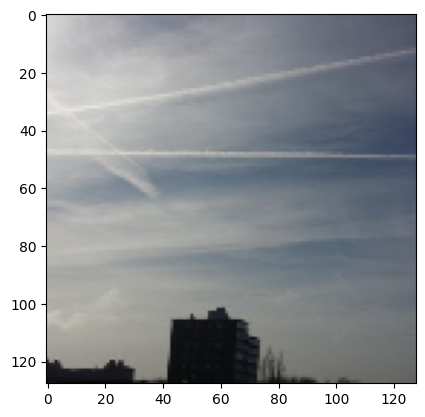

In [ ]:
plt.imshow(img)
plt.show()

* Add two more transformations to train_transforms to perform a random horizontal flip and then a rotation by a random angle between 0 and 45 degrees.
* Reshape the image tensor from the DataLoader to make it suitable for display.
* Display the image.

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset_train = ImageFolder(
  "/kaggle/input/cloud-dataset/data/train",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

ake a look at the image's edges. Can you see a frame of black pixels around it? That's the result of the image being rotated! The Dataset and DataLoaders you built in this lesson are ready to pass data to the cloud-classifying model. Next, we will talk about the model architecture suitable for this task.

# Building convolutional networks

You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

* A feature extractor that learns a vector of features from the input image,
* A classifier that predicts the image's class based on the learned features.

* Define the feature_extractor part of the model by adding another convolutional layer with 64 output feature maps, the ELU activation, and a max pooling layer with a window of size two; at the end, flatten the output.

* Define the classifier part of the model as a single linear layer with a number of inputs that reflects an input image of 64x64 and the feature extractor defined; the classifier should have num_classes outputs.

* In the forward() method, pass the input image x first through the feature extractor and then through the classifier.

In [9]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


The num_classes parameter in the Net class specifies the number of output classes that the neural network is designed to predict. This is a common setup for classification tasks, where the network needs to categorize input images into one of several predefined classes.

In [15]:
num_classes = 3
model = Net(num_classes)
print(model)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=3, bias=True)
)


We've built you first convolutional neural network for image classification! Most CNN architectures look similar: repeated blocks of convolution-activation-pooling with increasing number of feature maps, followed by a flatten and then one of more linear layers for classification or regression. It's now time to train your mode

**Dataset with augmentations**

You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

* Define train_transforms by composing together five transformations: a random horizontal flip, random rotation (by angle from 0 to 45 degrees), random automatic contrast adjustment, parsing to tensor, and resizing to 64 by 64 pixels.

In [17]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

dataset_train = ImageFolder(
  "/kaggle/input/cloud-dataset/data/train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

**Image classifier training loop**

It's time to train the image classifier! You will use the Net you defined earlier and train it to distinguish between seven cloud types.

To define the loss and optimizer, you will need to use functions from torch.nn and torch.optim, imported for you as nn and optim, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

* Define the model using your Net class with num_classes set to 7 and assign it to net.
* Define the loss function as cross-entropy loss and assign it to criterion.
* Define the optimizer as Adam, passing it the model's parameters and the learning rate of 0.001, and assign it to optimizer.
* Start the training for-loop by iterating over training images and labels.

In [ ]:
# Define the model
net = Net(num_classes = 7 )
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

[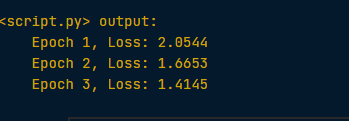](http://)

In [23]:
unique_labels = set()
for _, labels in dataloader_train:
    unique_labels.update(labels.numpy())
print(f"Unique labels in the dataset: {unique_labels}")


Unique labels in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


In [33]:
def adjust_label(label):
    # Assuming labels are originally in the range 1 to 8
    if 1 <= label <= 8:
        return label - 1
    else:
        return None  # Skip invalid labels


In [34]:
class AdjustLabelDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.valid_indices = self._get_valid_indices()

    def _get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.original_dataset)):
            _, label = self.original_dataset[idx]
            if adjust_label(label) is not None:
                valid_indices.append(idx)
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        image, label = self.original_dataset[actual_idx]
        adjusted_label = adjust_label(label)
        return image, adjusted_label


In [35]:
# Wrap your original dataset with the AdjustLabelDataset
adjusted_dataset = AdjustLabelDataset(dataset_train)
dataloader_train = torch.utils.data.DataLoader(adjusted_dataset, batch_size=32, shuffle=True)

# Define the model, loss function, and optimizer
net = Net(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


IndexError: Target 7 is out of bounds.